# 3.0a Cluster Analysis with Taxi Main DF

**Tasks**: Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods**: Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.
Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

## Outline of this notebook:
1. Helper Functions
2. Adding Additional Features
3. Feature Selection
4. ...

In [1]:
# Hexagon resolution to work with for the rest of the notebook
RES = 8

In [369]:
# Standard libraries - run pip install if necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from collections import Counter
from datetime import datetime

# Geospatial libraries
from h3 import h3 
import geopandas as gp
import folium
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
## Color for map 
import branca
import branca.colormap as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster import hierarchy

# progress bar
from tqdm import tqdm
tqdm.pandas()

In [3]:
# Color global palette
plt.rcParams['image.cmap'] = 'viridis'
sns.set_palette('viridis')

In [4]:
taxi_df = pd.read_csv("data/prepped/prep_taxidata.csv")

In [5]:
taxi_df.head(3)

,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,company_encoded,taxi_id_encoded,pickup_community,pickup_area_number,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff
0,0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31 23:45:00,2023-01-01 00:15:00,2081.0,4.42,NaN,NaN,20.50,...,0,0,WEST RIDGE,2,UPTOWN,3,872664d8effffff,872664d89ffffff,882664d8e1fffff,882664d897fffff
1,1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,13.84,...,0,1,NEAR NORTH SIDE,8,WEST TOWN,24,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff
2,2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31 23:45:00,2023-01-01 00:00:00,600.0,0.90,NaN,NaN,7.00,...,1,2,NEAR NORTH SIDE,8,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff


In [6]:
taxi_df.isna().sum()

Unnamed: 0                          0
trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           2884556
dropoff_census_tract          2884556
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude            0
pickup_centroid_longitude           0
pickup_centroid_location            0
dropoff_centroid_latitude           0
dropoff_centroid_longitude          0
dropoff_centroid_location           0
trip_hours                          0
1_hour_window                       0
1_hour_window_sin                   0
1_hour_window_cos                   0
4_hour_windo

In [7]:
pd.to_numeric(taxi_df["pickup_area_number"], downcast='integer')
pd.to_numeric(taxi_df["dropoff_area_number"], downcast='integer')

0           3
1          24
2           8
3           8
4           8
           ..
5320304    22
5320305    32
5320306    77
5320307     3
5320308     8
Name: dropoff_area_number, Length: 5320309, dtype: int8

In [8]:
# Check main df, if any big outliers still (comparing means) 
taxi_df.describe()

,Unnamed: 0,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,tolls,extras,trip_total,...,6_hour_window_sin,6_hour_window_cos,weekday,weekday_sin,weekday_cos,payment_type_encoded,company_encoded,taxi_id_encoded,pickup_area_number,dropoff_area_number
count,5.320309e+06,5.320309e+06,5.320309e+06,2.435753e+06,2.435753e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,...,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06
mean,3.185513e+06,1.096465e+03,5.370159e+00,1.703145e+10,1.703141e+10,1.931889e+01,2.398395e+00,1.364020e-03,1.096509e+00,2.296482e+01,...,-1.776307e-02,-3.434613e-01,2.881805e+00,5.711463e-02,-5.509035e-02,2.052332e+00,4.440882e+00,1.304573e+03,3.053719e+01,2.591548e+01
std,1.844741e+06,9.088033e+02,6.146649e+00,3.625628e+05,3.441342e+05,1.472827e+01,3.351792e+00,8.435670e-02,2.707011e+00,1.792594e+01,...,7.312071e-01,5.891139e-01,1.902813e+00,6.969205e-01,7.127447e-01,1.050919e+00,5.541477e+00,7.862590e+02,2.416608e+01,2.099785e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,1.703101e+10,1.703101e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.000000e+00,-1.000000e+00,0.000000e+00,-9.749279e-01,-9.009689e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,1.583122e+06,4.570000e+02,8.600000e-01,1.703108e+10,1.703108e+10,7.750000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.750000e+00,...,-1.000000e+00,-1.000000e+00,1.000000e+00,-4.338837e-01,-9.009689e-01,1.000000e+00,1.000000e+00,6.340000e+02,8.000000e+00,8.000000e+00
50%,3.183302e+06,8.070000e+02,2.220000e+00,1.703132e+10,1.703132e+10,1.232000e+01,9.200000e-01,0.000000e+00,0.000000e+00,1.500000e+01,...,1.224647e-16,-1.836970e-16,3.000000e+00,0.000000e+00,-2.225209e-01,2.000000e+00,3.000000e+00,1.257000e+03,2.800000e+01,2.800000e+01
75%,4.786210e+06,1.504000e+03,9.360000e+00,1.703184e+10,1.703184e+10,3.000000e+01,3.190000e+00,0.000000e+00,1.000000e+00,3.125000e+01,...,1.000000e+00,6.123234e-17,4.000000e+00,7.818315e-01,6.234898e-01,3.000000e+00,7.000000e+00,1.959000e+03,3.600000e+01,3.200000e+01
max,6.382424e+06,1.131100e+04,3.017000e+01,1.703198e+10,1.703198e+10,1.680000e+02,1.501000e+01,2.300000e+01,6.750000e+01,1.800000e+02,...,1.000000e+00,1.000000e+00,6.000000e+00,9.749279e-01,1.000000e+00,7.000000e+00,3.600000e+01,2.937000e+03,7.700000e+01,7.700000e+01


## 1.0 Helper functions

In [450]:
def most_common_variables(arrays, n=8):
    all_variables = [item for sublist in arrays for item in sublist]
    most_common = Counter(all_variables).most_common(n)
    most_common_variables = [variable for variable, count in most_common]
    return most_common_variables

In [410]:
# Feature Selection according to https://medium.com/analytics-vidhya/k-means-algorithm-in-4-parts-4-4-42bc6c781e46
def optimize_feature_selection(df_test_sample, maxvars=8, kmin=3, kmax=6):
    '''
    Input is sampled df (approx.  rows, else takes too long)
    Maximal number of variables we want to have 
    Minimum and maximum number of clusters for which we calculate the silhouette scores
    
    Returns the best cluster number and the most suitable variables for clustering
    '''
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_test_sample)
    
    results_for_each_k = []
    vars_for_each_k = {}
    
    kmeans_kwargs = {"init": "k-means++","n_init": 10,"random_state": 1984}
    
    for k in range(kmin, kmax + 1):
        cols = list(df_test_sample.columns)
        selected_variables = []
        
        for _ in range(maxvars):
            results = []
            for col in cols:
                scols = selected_variables + [col]
                kmeans = KMeans(n_clusters=k,**kmeans_kwargs)
                kmeans.fit(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in scols]])
                
                # Silhouette score can only be calculated if more than 1 label, hence append -1 score if clustering yielded <= 1
                unique_labels = np.unique(kmeans.labels_)
                if len(unique_labels) > 1:
                    score = silhouette_score(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in scols]], 
                                             kmeans.labels_)
                    results.append(score)
                else:
                    results.append(-1) 
            
            selected_var = cols[np.argmax(results)]
            selected_variables.append(selected_var)
            cols.remove(selected_var)
        
        results_for_each_k.append(max(results))
        vars_for_each_k[k] = selected_variables
    
    best_k = np.argmax(results_for_each_k) + kmin
    selected_variables = vars_for_each_k[best_k]
    
    kmeans = KMeans(n_clusters=best_k, **kmeans_kwargs)
    kmeans.fit(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in selected_variables]])
    #clusters = kmeans.predict(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in selected_variables]])
    
    return best_k, selected_variables #clusters

In [11]:
# Scaling
def scale_df(X):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(X)
    return pd.DataFrame(df_scaled, columns=X.columns, index=X.index)

In [12]:
# Dimensionality Reduction via PCA
def number_of_componentsPCA(X_scaled):
    pca = PCA()
    pca.fit(X_scaled)
    per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)

    plt.figure(figsize = (8,6))
    plt.plot(range(1, len(per_var)+1), per_var.cumsum(), marker = "o", linestyle = "--")
    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    
    plt.axhline(y=90, color='r', linestyle='-')
    
    plt.ylabel("Percentage Cumulative of Explained Variance")
    plt.xlabel("Number of Components")
    plt.title("Explained Variance by Component")
    plt.show()

In [13]:
# Perform PCA 
def do_pca(X_scaled, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(X_scaled)
    return pca.transform(X_scaled)

In [14]:
# Heatmap for feature selection
def heatmap(scaled_dataframe, x=10, y=10):
    corr_matrix = scaled_dataframe.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=(x, y))
    sns.heatmap(corr_matrix,
            mask = mask,
            annot=True, 
            cmap='viridis', 
            vmin=0, 
            vmax=1,
            linewidth=1, linecolor="w", square=True
           )
    plt.title('Feature Importances using Correlation-Matrix')
    plt.show()

In [15]:
# Grid search
def elbow_method(df_scaled, max_clusters=10):
    loss = []
    for k in tqdm(range(1, max_clusters+1)):
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(df_scaled)
        loss.append(km.inertia_)

    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    plt.plot(range(1, max_clusters+1), loss, marker='o', linestyle='--')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS Loss')
    plt.title('Elbow Method with K-Means++')
    plt.show()

In [544]:
# Silhouette scores according to different cluster numbers
def plot_silhouette_scores(data, k_max):
    # 10000 rows only since computationally expensive else
    df_sampled = data.sample(n=10000, random_state=42)
    
    ncols = 3
    # calculate number of rows
    nrows = k_max // ncols + (k_max % ncols > 0)
    fig = plt.figure(figsize=(15,15), dpi=200)
    
    for k in tqdm(range(2, k_max+1)):
        km = KMeans(init='k-means++', n_clusters=k, n_init=10, random_state=42)
        km_fit = km.fit(df_sampled)
    
        # Visualize
        ax = plt.subplot(nrows, ncols, k-1)
        silhouette_plot(df_sampled, km_fit, ax)
        
    fig.suptitle("Silhouette plots", fontsize=18, y=1)
    plt.tight_layout()
    plt.show()

In [555]:
# Silhouette Plot for (works only for small sample else too computationally expensive!)
# Medium Best Practices for Visualizing Your Cluster Results
def silhouette_plot(X, model, ax):
    y_lower = 10
    y_tick_pos_ = []
    sh_samples = silhouette_samples(X, model.labels_)
    sh_score = silhouette_score(X, model.labels_)
    
    colors = sns.color_palette('viridis', model.n_clusters)
    
    ax.grid(True, linestyle='--', alpha=0.7, color='lightgrey', zorder=1)
    
    for idx in range(model.n_clusters):
        values = sh_samples[model.labels_ == idx]
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, values, facecolor=colors[idx], edgecolor=colors[idx], zorder=2)
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 10

    ax.axvline(x=sh_score, color="red", linestyle="--", label="Avg Silhouette Score")
    ax.set_title("Silhouette Plot for {} clusters".format(model.n_clusters))
    l_xlim = max(-1, min(-0.1, round(min(sh_samples) - 0.1, 1)))
    u_xlim = min(1, round(max(sh_samples) + 0.1, 1))
    ax.set_xlim([l_xlim, u_xlim])
    ax.set_ylim([0, X.shape[0] + (model.n_clusters + 1) * 10])
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(model.n_clusters))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
    ax.legend(loc="best")
    return ax

Silhouette Score measures goodness of fit for different cluster numbers by (b-a)/max(a,b) where:
- b: average distance between all clusters
- a: average distance between each point within a cluster

The score is between [-1, 1], where
- -1 means clusters are assigned wrong
- 1 means clusters are well apart 
- 0 means cluster distance is not significant

(https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

In [575]:
# Visualize cluster representation by plotting magnitude and cardinality of clusters
def visualize_cluster_representative_power(original_df, df_scaled, cluster_col_name, model):
    fig, axes = plt.subplots(nrows= 1, ncols=2, figsize=(12, 10))
    
    axes = axes.flatten()
    
    axes[0].grid(True, linestyle='--', alpha=0.7, color='lightgrey', zorder=1)
    axes[1].grid(True, linestyle='--', alpha=0.7, color='lightgrey', zorder=1)
    
    # 1. Plot cluster cardinality
    count = sns.countplot(original_df, x=cluster_col_name, hue=cluster_col_name, palette="viridis", ax=axes[0], zorder=2)
    axes[0].set_title('Cluster Cardinality')
    axes[0].set_xlabel('Cluster Label')
    axes[0].set_ylabel('Points in Cluster')
    axes[0].legend()
    
    for p in count.patches:
        count.annotate(f'\n{p.get_height()}', (p.get_x()+0.5, p.get_height()), ha='center', va='top', color='white', size=14)
    
    ## 2. Plot cluster magnitudes
    dist = model.transform(df_scaled).sum(axis=1)
    df_magnitude = pd.DataFrame(dist.round(2), columns=['distance_to_cluster_center'])
    df_magnitude[cluster_col_name] = kmeans.labels_
    df_magnitude = df_magnitude.groupby(cluster_col_name).sum().reset_index()
    sns.barplot(x=cluster_col_name, y="distance_to_cluster_center", data=df_magnitude, palette="viridis", hue=cluster_col_name, ax=axes[1], zorder=2)
    
    axes[1].set_title('Cluster Magnitude')
    axes[1].set_xlabel('Cluster Label')
    axes[1].set_ylabel('Total Point-to-Centroid Distance')
    axes[1].legend()
    
    ## 3. Plot magnitude vs. cardinality
    #colors = sns.color_palette('viridis', n_clusters)
    #axes[1, 0].scatter(cluster_cardinality, cluster_magnitudes, color=colors)
    #for i in range(n_clusters):
    #    axes[1, 0].text(cluster_cardinality[i], cluster_magnitudes[i], str(i))
    #axes[1, 0].plot(cluster_cardinality, cluster_magnitudes, color='blue')
    #axes[1, 0].set_title('Magnitude vs. Cardinality')
    #axes[1, 0].set_xlabel('Cardinality')
    #axes[1, 0].set_ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()

After clustering with the determined optimal number of clusters has been applied, you should have a look at the cluster results.
It is very useful to focus on properties such as:
- Cluster Cardinality: The cluster cardinality, or the cluster sizes, plot shows the number of points per cluster
- Cluster Magnitude: shows the total point to centroid distance per cluster. This chart can be used to see how high is the ‘spread’ of the points in each cluster and if there are any clumpy or wide clusters
####- Magnitude vs. Cardinality: compares cluster cardinality with cluster magnitude. Clusters with a higher cardinality tend to also have a higher cluster magnitude. The idea is that normal clusters lie on or are very close to the 45-degree line. Anomalies tend to lie more distant from it. In our example cluster 1 is anomalous.

## 2.0 Adding Additional Features 
You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.

In [19]:
taxi_add_features = taxi_df.copy()

### 2.0.1 Temporal Features

In [20]:
taxi_add_features["trip_start_timestamp"] = pd.to_datetime(taxi_df["trip_start_timestamp"])
taxi_add_features["trip_end_timestamp"] = pd.to_datetime(taxi_df["trip_end_timestamp"])

In [21]:
# Get weekday or not (0 if not, 1 if it is)
taxi_add_features['is_weekday'] = (taxi_df["weekday"] < 5).astype(int)

### 2.0.2 Distance to city center

In [22]:
# City center = hexagon with the most pickups
center_hex = taxi_df[f'h3_res{RES}_pickup'].value_counts().idxmax()

print(f'Center hexagon: {center_hex}')
taxi_add_features[taxi_add_features[f'h3_res{RES}_pickup'] == center_hex].iloc[0].pickup_community

Center hexagon: 882664c1edfffff


'NEAR NORTH SIDE'

In [23]:
# Calculate grid distances
def calculate_h3_grid_distances(df, center_hex):
    df[f'dist_from_center_pickup'] = df[f'h3_res{RES}_pickup'].apply(lambda x: h3.h3_distance(x, center_hex))
    df[f'dist_from_center_dropoff'] = df[f'h3_res{RES}_dropoff'].apply(lambda x: h3.h3_distance(x, center_hex))
    
    return df

In [24]:
taxi_add_features = calculate_h3_grid_distances(taxi_add_features, center_hex)

### 2.0.3 Trip Direction

If we are moving towards the center, then the direction (distance between pickup and dropoff) is positive, whereas moving away from the city center gives us a negative distance

In [25]:
# Get the direction of the trip
taxi_add_features['moving_towards_center'] = taxi_add_features['dist_from_center_pickup'] - taxi_add_features['dist_from_center_dropoff'] 

In [26]:
taxi_add_features[taxi_add_features['moving_towards_center'] < 0].head(3)

,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,is_weekday,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center
1,1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,13.84,...,WEST TOWN,24,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff,0,0,4,-4
6,6,32c54ad25f76c07b29bc59b04f9f196cf811ed67,cb1a522e6e968cbebb7ce23e6775a4769de4aeb2154fa5...,2022-12-31 23:45:00,2023-01-01 00:00:00,876.0,8.91,NaN,NaN,23.75,...,AUBURN GRESHAM,71,872664c1bffffff,872664cd8ffffff,882664c1b5fffff,882664cd89fffff,0,6,23,-17
7,8,3186be22cdd5d17def50e44eca6be9ec9b0a9974,4f78222d267c08ee7267810e5f3f2241dc61bf1396d036...,2022-12-31 23:45:00,2022-12-31 23:45:00,540.0,0.70,1.703108e+10,1.703184e+10,7.25,...,LOOP,32,872664c1effffff,872664c1affffff,882664c1e7fffff,882664c1a9fffff,0,2,3,-1


### 2.0.4 Drop redundant columns

To prepare the dataset for the next step of feature selection, we first want to drop any columns that are trivial for feature selection and the later clustering process, since either the columns are already available in another form, or they are not contributing to cluster formation. Columns that were dropped and why:
- Dropped trip_id, **DROP encoded_taxi_id TODOOOOOOOOOOOOOO** and taxi_id: they were identified as non-contributory to the customer groups, adding no value
- Dropped trip_start_time and trip_end_timestamp: already encoded in more granular form e.g. end_hour, trip_hours, is_weekday etc.
- Dropped any already encoded columns, such as payment_type or company
- Dropped columns with detailed geographical such as location as we have lat/lng given
- Dropped non string column dropoff/pickup_community as encoded column given (area_number)
- Dropped census_tract since available in other forms and missing data is avoided

In [27]:
taxi_add_features.columns

Index(['Unnamed: 0', 'trip_id', 'taxi_id', 'trip_start_timestamp',
       'trip_end_timestamp', 'trip_seconds', 'trip_miles',
       'pickup_census_tract', 'dropoff_census_tract', 'fare', 'tips', 'tolls',
       'extras', 'trip_total', 'payment_type', 'company',
       'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude',
       'dropoff_centroid_longitude', 'dropoff_centroid_location', 'trip_hours',
       '1_hour_window', '1_hour_window_sin', '1_hour_window_cos',
       '4_hour_window', '4_hour_window_sin', '4_hour_window_cos',
       '6_hour_window', '6_hour_window_sin', '6_hour_window_cos', 'weekday',
       'weekday_sin', 'weekday_cos', 'payment_type_encoded', 'company_encoded',
       'taxi_id_encoded', 'pickup_community', 'pickup_area_number',
       'dropoff_community', 'dropoff_area_number', 'h3_res7_pickup',
       'h3_res7_dropoff', 'h3_res8_pickup', 'h3_res8_dropoff', 'is_weekday',
       'dist_from_center_p

In [424]:
# Drop unneeded columns for further steps  TODO FIX
columns_to_drop = ['Unnamed: 0','trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
                   'trip_hours',
                   'pickup_census_tract', 'dropoff_census_tract', 
                   'payment_type', 'company', 
                   #'pickup_centroid_latitude', 'pickup_centroid_longitude', 
                   'pickup_centroid_location', 
                   #'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 
                   'dropoff_centroid_location',
                   "pickup_community", "dropoff_community"
                  ]
prep_df = taxi_add_features.drop(columns_to_drop, axis=1)
prep_df.head()

,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,...,pickup_area_number,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,is_weekday,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center
0,2081.0,4.42,20.50,0.00,0.0,0.0,20.50,42.001571,-87.695013,41.965812,...,2,3,872664d8effffff,872664d89ffffff,882664d8e1fffff,882664d897fffff,0,13,8,5
1,812.0,0.00,13.84,2.73,0.0,0.0,16.57,41.899602,-87.633308,41.901207,...,8,24,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff,0,0,4,-4
2,600.0,0.90,7.00,2.00,0.0,3.0,12.00,41.899602,-87.633308,41.899602,...,8,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff,0,0,0,0
3,546.0,0.85,6.50,0.00,0.0,0.0,6.50,41.899602,-87.633308,41.899602,...,8,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff,0,0,0,0
4,574.0,0.33,6.25,0.00,0.0,0.0,6.25,41.899602,-87.633308,41.899602,...,8,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff,0,0,0,0


We also want to drop non-numerical columns, as they either are not relevant or are available in encoded form. Furthermore, we drop the 1_ to 6_hour_window columns, as we use their sin/cos encoded forms.

In [425]:
non_numerical = [
       'h3_res7_pickup', 'h3_res7_dropoff',
       'h3_res8_pickup', 'h3_res8_dropoff',
    '1_hour_window','4_hour_window','6_hour_window', 
# TODO: DROP IN ORIGINAL FRAME TOO NOONE USES THESE
    #'payment_type_encoded', 
    'company_encoded', 
    'taxi_id_encoded',
]
prep_df_preselection = prep_df.drop(non_numerical, axis=1)

### 2.0.5 Drop related columns

Next we want to take a look at the similarities between features in order to avoid multi-collinearity. For this, we first visualize the current features using a dendogram and a heatmap.

In [426]:
# Standardize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(prep_df_preselection)
df_scaled = pd.DataFrame(df_scaled, columns=prep_df_preselection.columns)

In [427]:
# Get correlations
corr_matrix = df_scaled.corr()

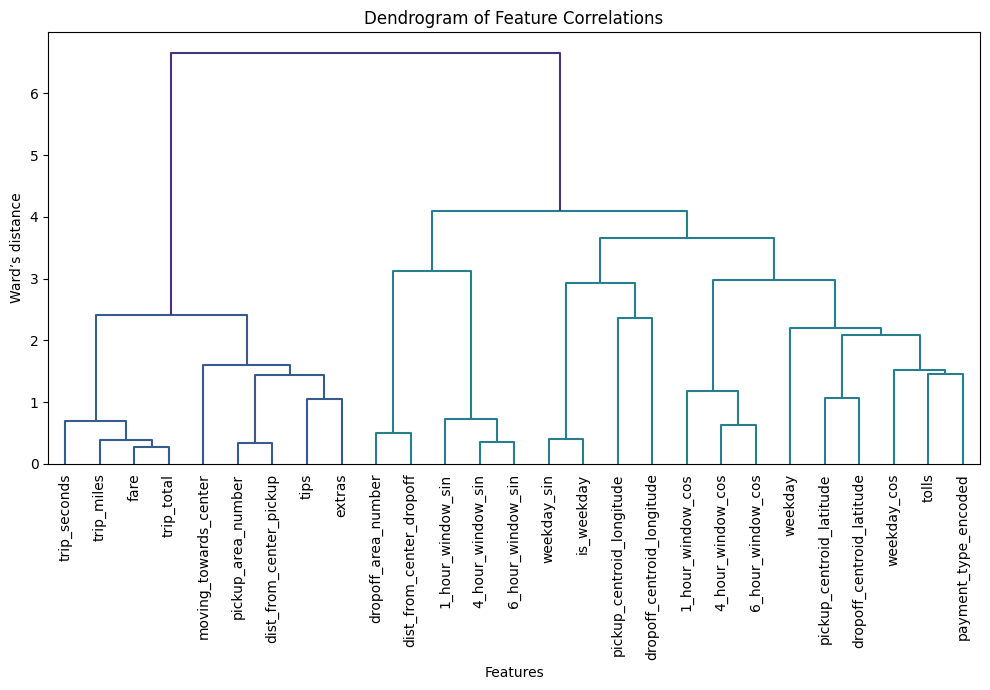

In [428]:
# Create dendogram
plt.figure(figsize=(10, 7))

linked= hierarchy.linkage(corr_matrix, method='ward')
dendrogram = hierarchy.dendrogram(linked, labels=corr_matrix.columns, leaf_rotation=90)

plt.xlabel('Features')
plt.ylabel('Ward’s distance')
plt.title('Dendrogram of Feature Correlations')
plt.tight_layout()
plt.show()

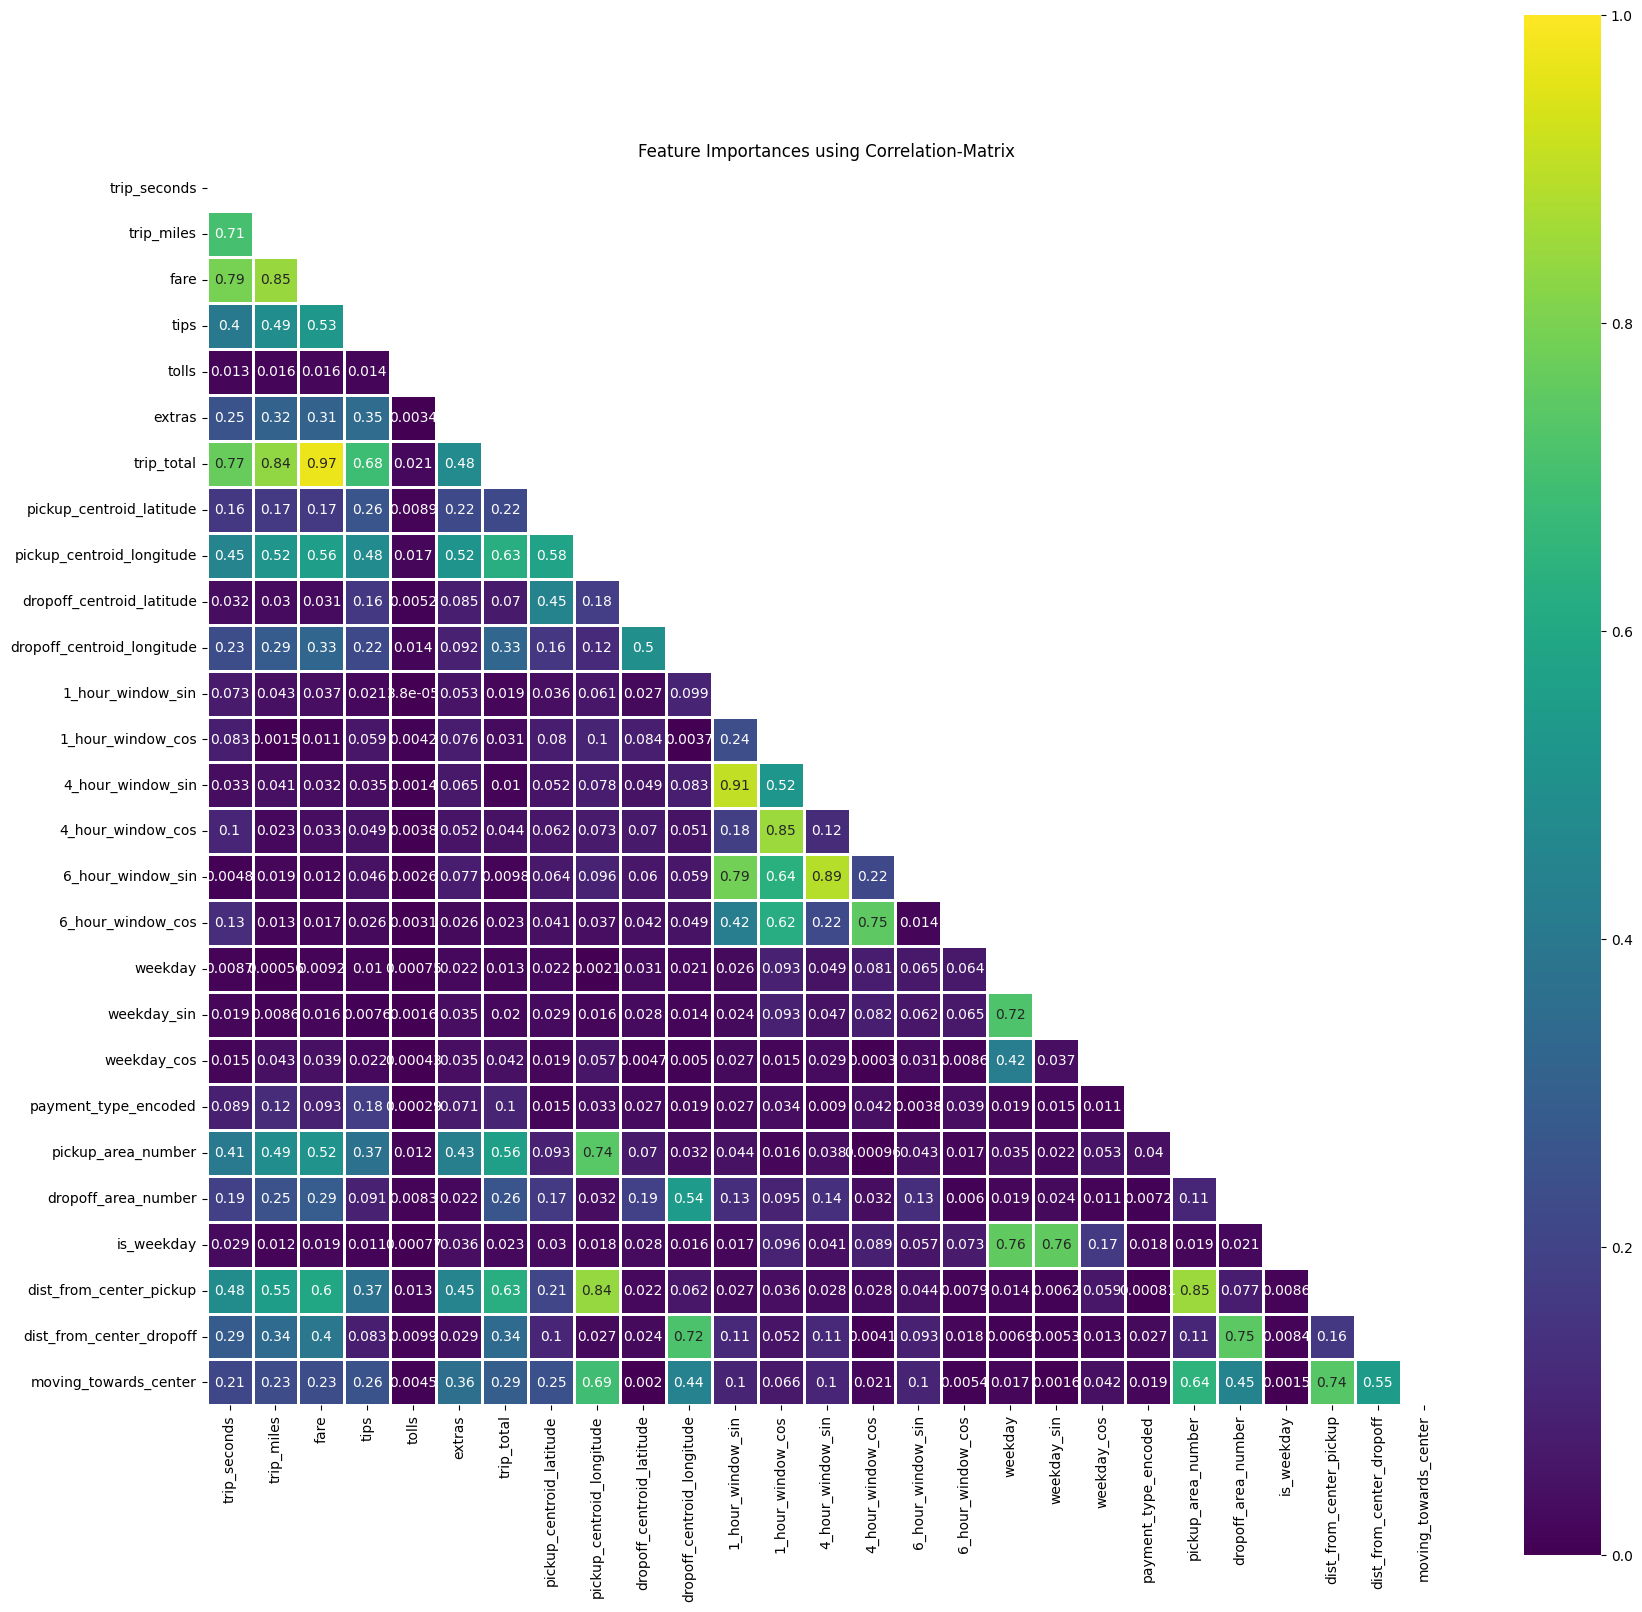

In [429]:
# Heatmap for further correlation info
heatmap(df_scaled, x=20, y=20)

We can see which features are strongly correlated by the small ward's distance as well as by correlation matrix. For highly correlated features, we only keep at most one, as else we are risking multi-collinearity. 
We observe:
1. Highly correlated features
    - 1_, 4_ and 6_hour_window_sin: should only keep one, in particular 1_hour_window, as shows generally lower correlations and bigger ward's distance
    - fare and trip_total: we keep only trip_total
    - weekday_sin, is_weekday: we keep weekday_cos instead
2. Highly-correlated features that have indications/provide potentially additional information
    - pickup_centroid_longitude and the distance from center pickup have high correlaiton
    - pickup/dropoff area number and the respective distance columns have high correlations

In [563]:
to_drop = [ 
    'fare', 'tolls', 'tips', 'extras',
    '1_hour_window_sin', "weekday_sin",
    '4_hour_window_sin', '4_hour_window_cos', 
    '6_hour_window_sin', '6_hour_window_cos',
    'weekday',
    # TODO REMOVE EVEN ADDING IS_WEEKDAY ________________
    'is_weekday'
]
df_features = prep_df_preselection.drop(to_drop, axis=1).copy()
df_features.shape

(5320309, 15)

In [478]:
df_features.head()

,trip_seconds,trip_miles,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,1_hour_window_cos,weekday_cos,payment_type_encoded,pickup_area_number,dropoff_area_number,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center
0,2081.0,4.42,20.50,42.001571,-87.695013,41.965812,-87.655879,0.965926,-0.222521,0,2,3,13,8,5
1,812.0,0.00,16.57,41.899602,-87.633308,41.901207,-87.676356,0.965926,-0.222521,1,8,24,0,4,-4
2,600.0,0.90,12.00,41.899602,-87.633308,41.899602,-87.633308,0.965926,-0.222521,2,8,8,0,0,0
3,546.0,0.85,6.50,41.899602,-87.633308,41.899602,-87.633308,0.965926,-0.222521,3,8,8,0,0,0
4,574.0,0.33,6.25,41.899602,-87.633308,41.899602,-87.633308,0.965926,-0.222521,3,8,8,0,0,0


## 3.0 Clustering 

### 3.1 Feature Selection

In [564]:
# Drop dropoff related columns? ---- EDIT: did not get into feature selection only dist_dropoff
df_features = df_features.drop(['dropoff_centroid_latitude', 'dropoff_centroid_longitude',], axis=1)

In [514]:
all_selected_variables = []
best_k_all = []

for i in tqdm(range(0, 5), desc="Sampling"):
    df_test_sample = df_features.sample(n=3000)
    best_k, selected_variables = optimize_feature_selection(df_test_sample)
    best_k_all.append(best_k)
    all_selected_variables.append(selected_variables)

Sampling:   0%|                                                                                  | 0/5 [00:00<?, ?it/s]C:\Users\25mad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\25mad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
Sampling:  20%|██████████████▊                                                           | 1/5 [00:58<03:54, 58.58s/it]C:\Users\25mad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  r

In [568]:
print("k:",best_k_all,"\nvariables:",all_selected_variables)
common_selected_var = most_common_variables(all_selected_variables, n=8) 
common_selected_var
# LAST RUN:
# common_selected_var =
# ['weekday_cos',
# 'pickup_centroid_longitude',
# 'dist_from_center_pickup',
# 'pickup_centroid_latitude',
# 'pickup_area_number',
# 'moving_towards_center',
# 'dist_from_center_dropoff',
# 'trip_total']

k: [4, 4, 4, 4, 4] 
variables: [['weekday_cos', 'pickup_centroid_longitude', 'dist_from_center_pickup', 'pickup_centroid_latitude', 'pickup_area_number', 'moving_towards_center', 'dist_from_center_dropoff', 'trip_miles'], ['weekday_cos', 'pickup_centroid_longitude', 'dist_from_center_pickup', 'pickup_centroid_latitude', 'pickup_area_number', 'moving_towards_center', 'dist_from_center_dropoff', 'trip_total'], ['weekday_cos', 'pickup_centroid_longitude', 'dist_from_center_pickup', 'pickup_centroid_latitude', 'pickup_area_number', 'moving_towards_center', 'dist_from_center_dropoff', 'trip_total'], ['weekday_cos', 'pickup_centroid_longitude', 'dist_from_center_pickup', 'pickup_centroid_latitude', 'pickup_area_number', 'moving_towards_center', 'dist_from_center_dropoff', 'trip_total'], ['weekday_cos', 'pickup_centroid_longitude', 'dist_from_center_pickup', 'pickup_centroid_latitude', 'pickup_area_number', 'moving_towards_center', 'dist_from_center_dropoff', 'trip_total']]


['weekday_cos',
 'pickup_centroid_longitude',
 'dist_from_center_pickup',
 'pickup_centroid_latitude',
 'pickup_area_number',
 'moving_towards_center',
 'dist_from_center_dropoff',
 'trip_total']

In [580]:
df_common_features = df_features[common_selected_var]

In [581]:
# Set an original feature df
df_original_features = df_features.copy()

### 3.2 Number of Clusters

In [582]:
# Standardize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_common_features)
df_features_scaled = pd.DataFrame(df_scaled, columns=df_common_features.columns)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.40s/it]


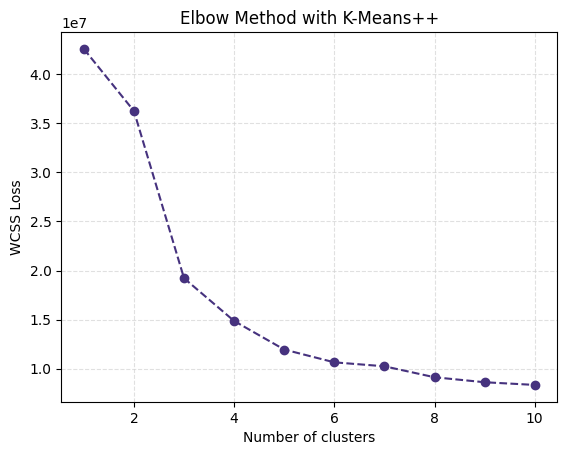

In [583]:
# Use elbow method to get number of clusters
elbow_method(df_features_scaled)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.65s/it]


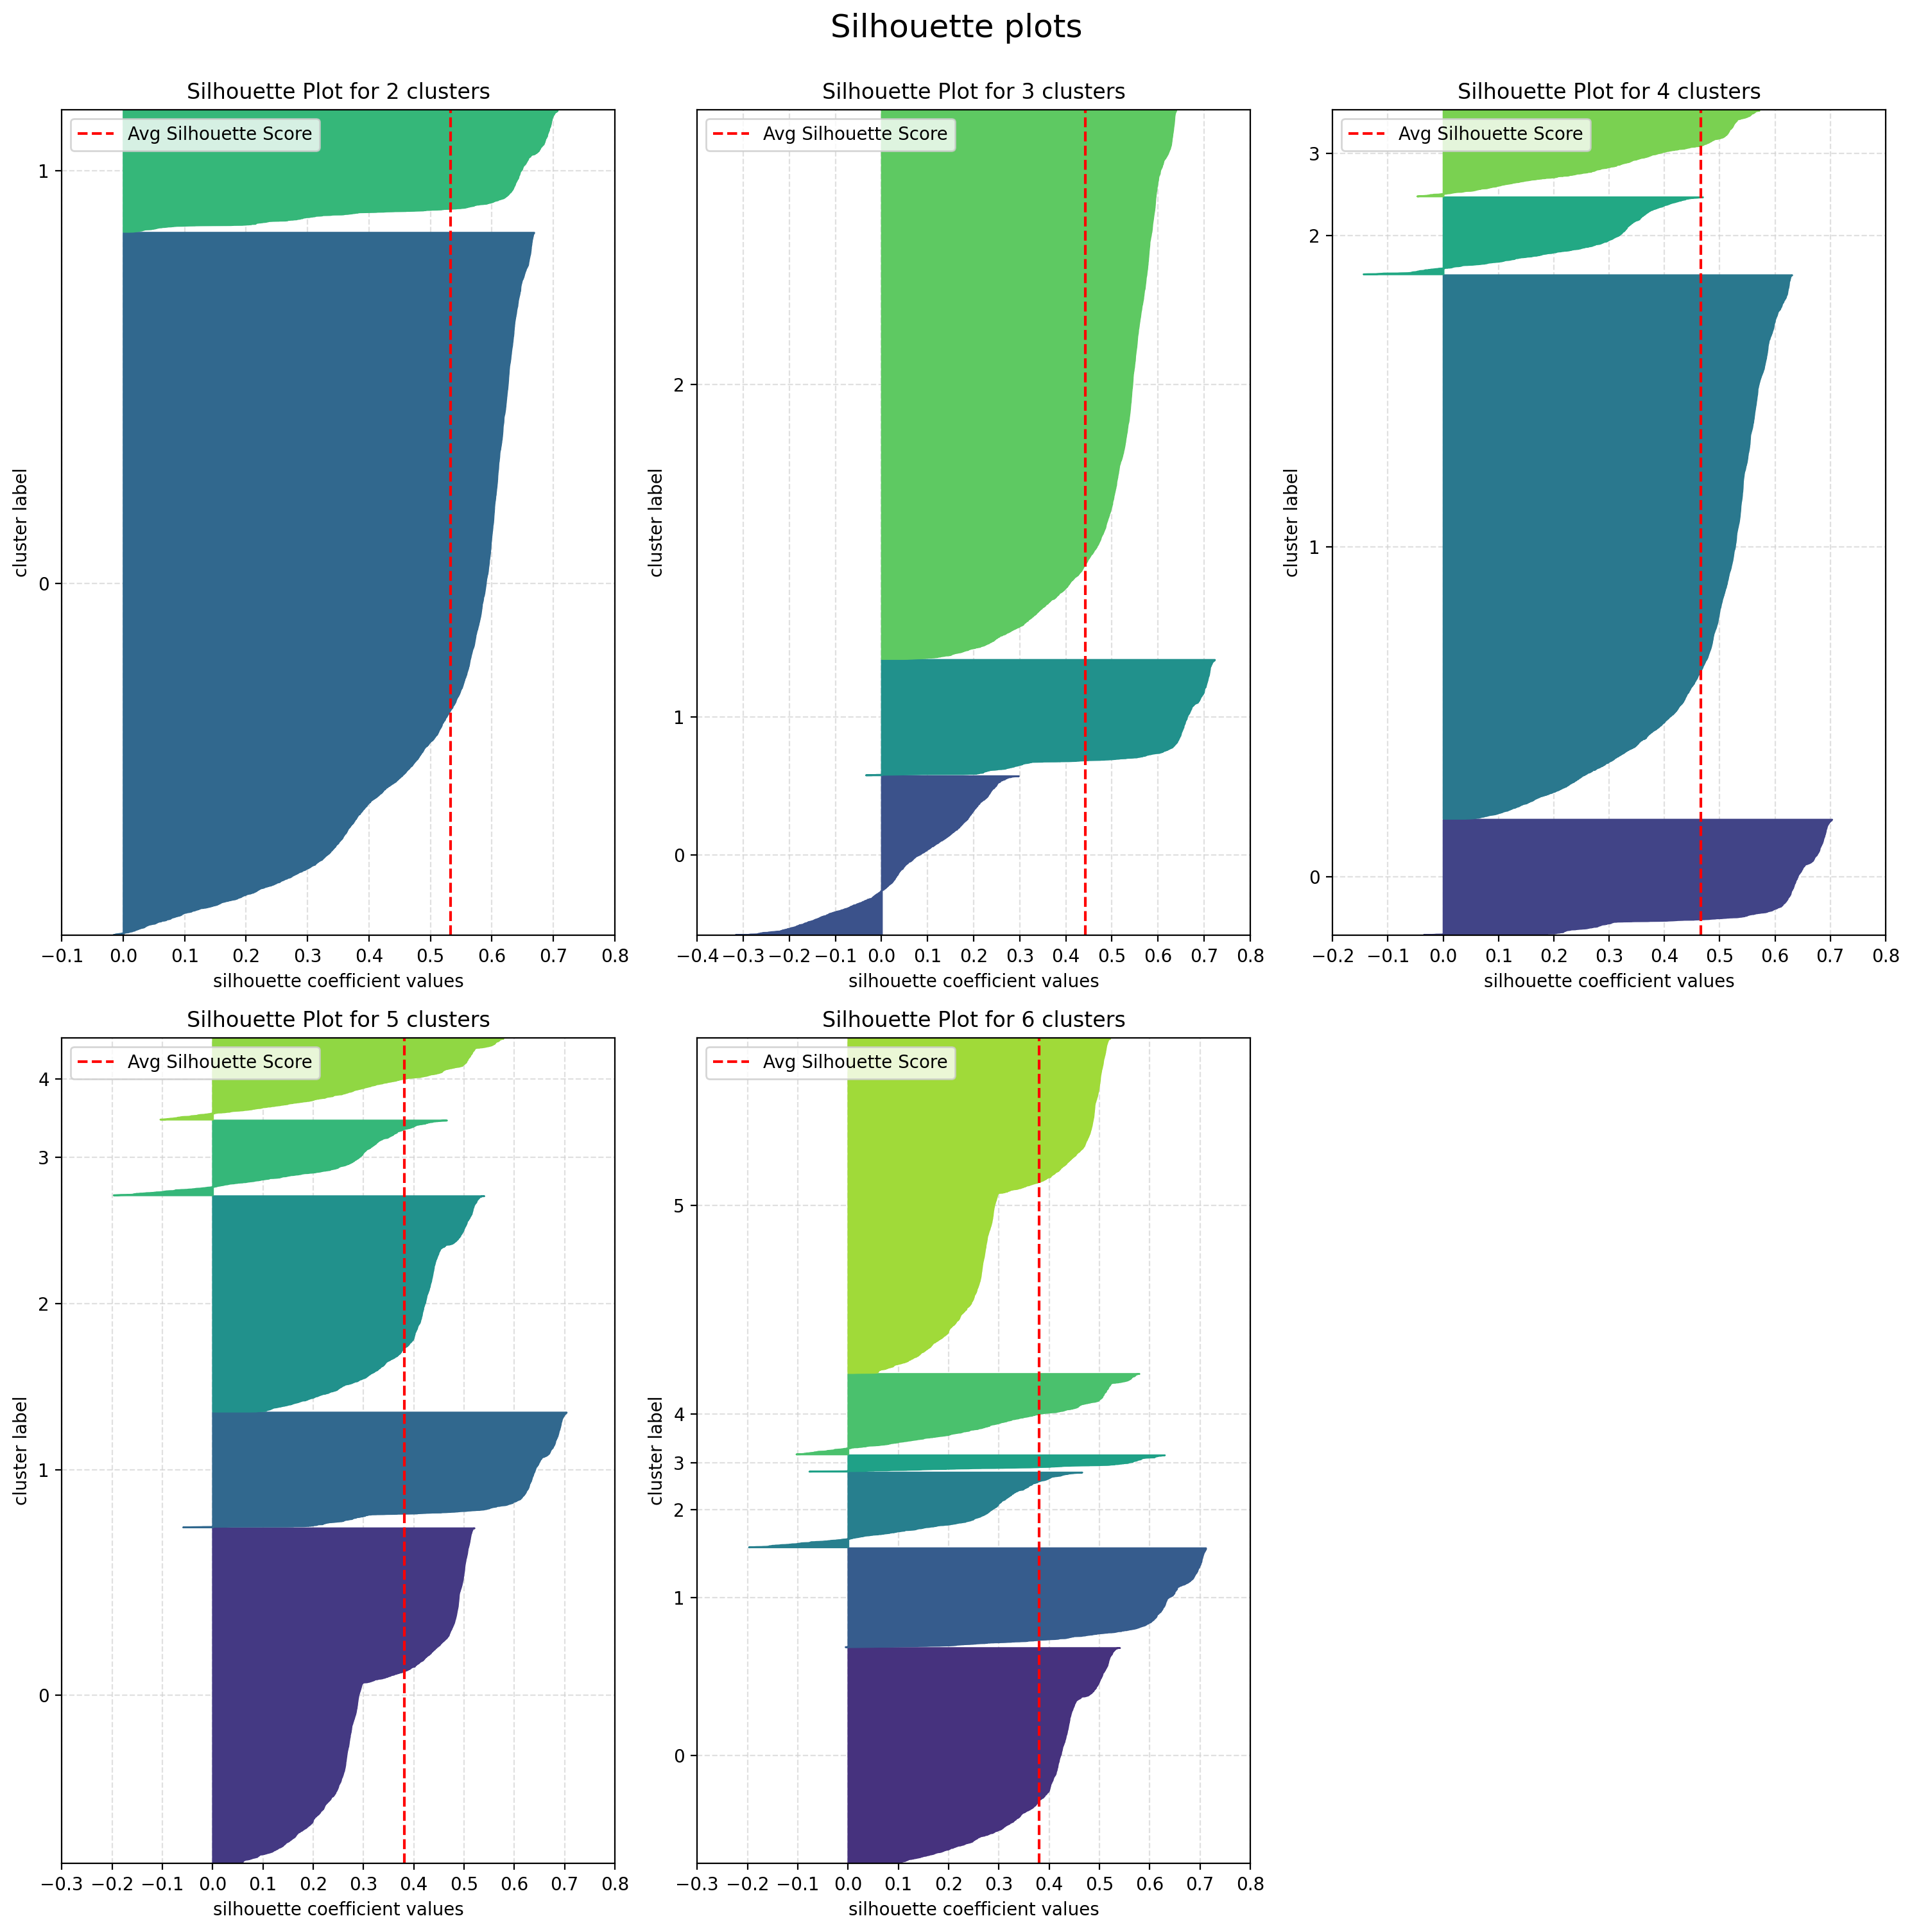

In [585]:
# Verify elbow method using silhouette scores
plot_silhouette_scores(df_features_scaled, 6)

Based on the curve, we can see that the curve is smoothed from point "Number of cluster" = 4, indicating our elbow point. We additionally verify these results by comparing silhouette scores of kmeans++ for different cluster numbers. This, however, is only done for a small sample of the original dataframe **(10.000 entries)** since else silhouette scores are very computationally expensive to compute. We can see similar results for a cluster number of 4.  

In [586]:
# Set the max number of clusters for the following tasks
CLUSTER_NUMBER = 4

### 3.3 K-means++ and GMM

In [587]:
# Run kmeans++ (10 iterations)
kmeans = KMeans(n_clusters = CLUSTER_NUMBER, n_init=10)
df_original_features['cluster_kmeans++'] = kmeans.fit_predict(df_features_scaled)

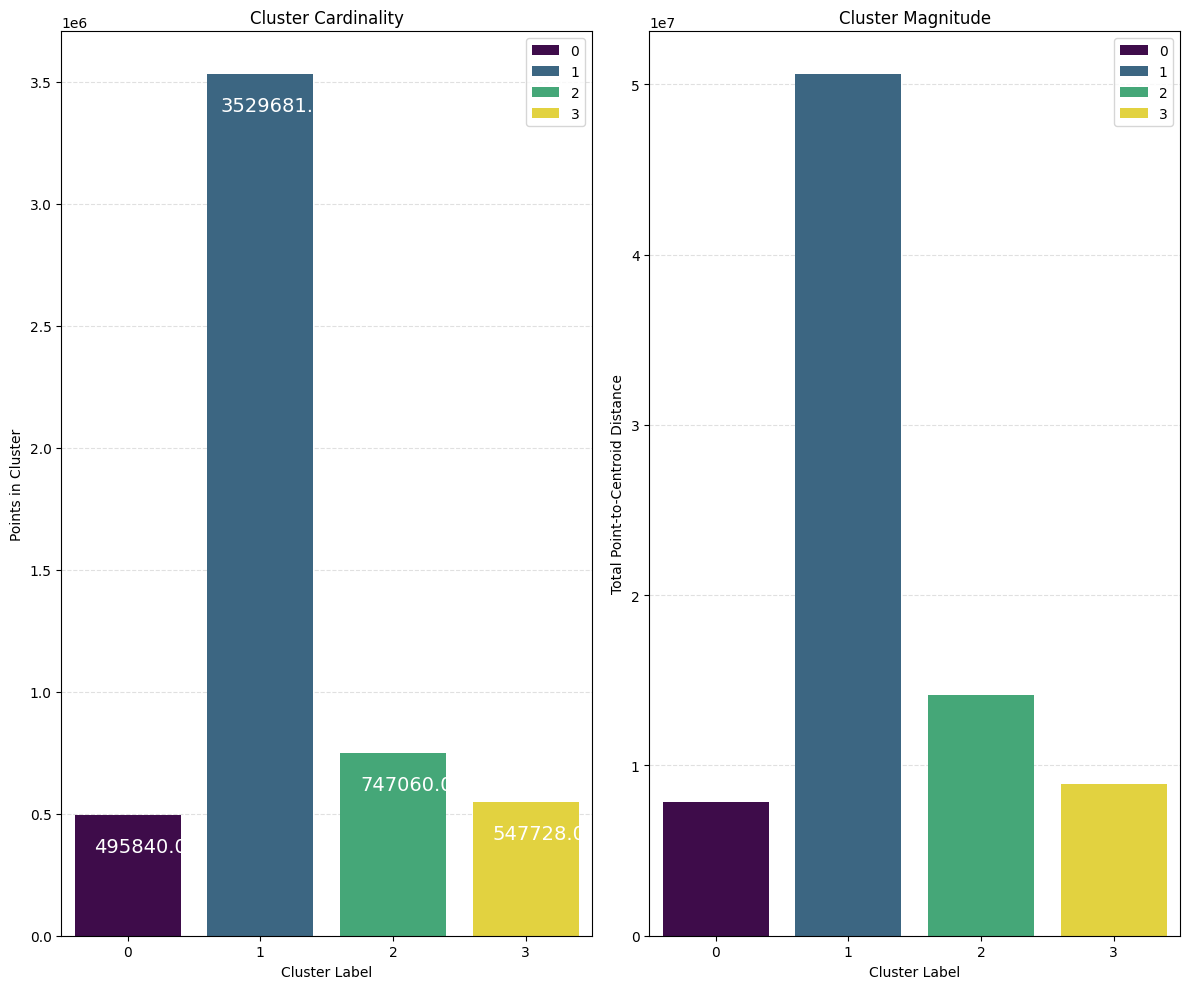

In [588]:
visualize_cluster_representative_power(original_df=df_original_features, df_scaled=df_features_scaled, cluster_col_name="cluster_kmeans++", model=kmeans)

While usually it is best for the representative power of the clusters to be of similar size, this might be explainable through furhter analysis. 

In [589]:
# What characteristic represents each cluster the most? 
cluster_means = df_original_features.groupby(['cluster_kmeans++']).mean().T
cluster_means

cluster_kmeans++,0,1,2,3
trip_seconds,1437.935233,711.563080,2079.495861,1926.955354
trip_miles,7.820677,2.295716,13.219680,12.258026
trip_total,30.233313,13.181567,50.027216,42.519224
pickup_centroid_latitude,41.772323,41.899326,41.979641,41.887910
pickup_centroid_longitude,-87.659618,-87.640141,-87.906448,-87.638643
1_hour_window_cos,-0.365773,-0.285191,-0.166098,-0.404234
weekday_cos,-0.019017,-0.081010,0.041308,-0.052194
payment_type_encoded,1.945468,2.064202,2.174618,1.905789
pickup_area_number,52.151311,19.299625,75.517122,22.038727
dropoff_area_number,34.861951,19.677396,25.275750,58.888671


We observe for each cluster: - --- TODO DONT RUN BEFORE ELSE RENUMBER_____________________________---

Cluster 0
- Moderate trip duration and distance
- Moderate trip total
- Pickup and dropoff locations are moderately far from the city center, pickup location is second most far out
- Moving towards the center

Cluster 1
- Shortest trip duration and distance (miles)
- Lowest trip total
- Pickup and dropoff locations close to another
- Moving on average slightly away from center

Cluster 2
- Longest trip durations and distance
- Highest trip total
- Pickup location farthest away from city center, dropoff close to center
- Moving towards center

Cluster 3
- Long trip duration and distance, similar to Cluster 2
- High trip total
- Pickup locations are central, dropoff locations are farthest from center
- Moving away from the center.


In [590]:
# Calculate the relative differences 
overall_mean = cluster_means.T.mean()
relative_differences = cluster_means.copy()

for cluster in cluster_means.columns:
    relative_differences[cluster] = (overall_mean - cluster_means[cluster] ) / overall_mean

relative_differences

cluster_kmeans++,0,1,2,3
trip_seconds,0.065661,0.537642,-0.351210,-0.252093
trip_miles,0.121127,0.742012,-0.485604,-0.377535
trip_total,0.110532,0.612197,-0.471807,-0.250921
pickup_centroid_latitude,0.002685,-0.000347,-0.002264,-0.000074
pickup_centroid_longitude,0.000588,0.000810,-0.002226,0.000827
1_hour_window_cos,-0.197984,0.065941,0.455996,-0.323953
weekday_cos,0.314173,-1.921582,2.489754,-0.882345
payment_type_encoded,0.038096,-0.020609,-0.075203,0.057715
pickup_area_number,-0.234301,0.543222,-0.787316,0.478394
dropoff_area_number,-0.005364,0.432535,0.271087,-0.698257


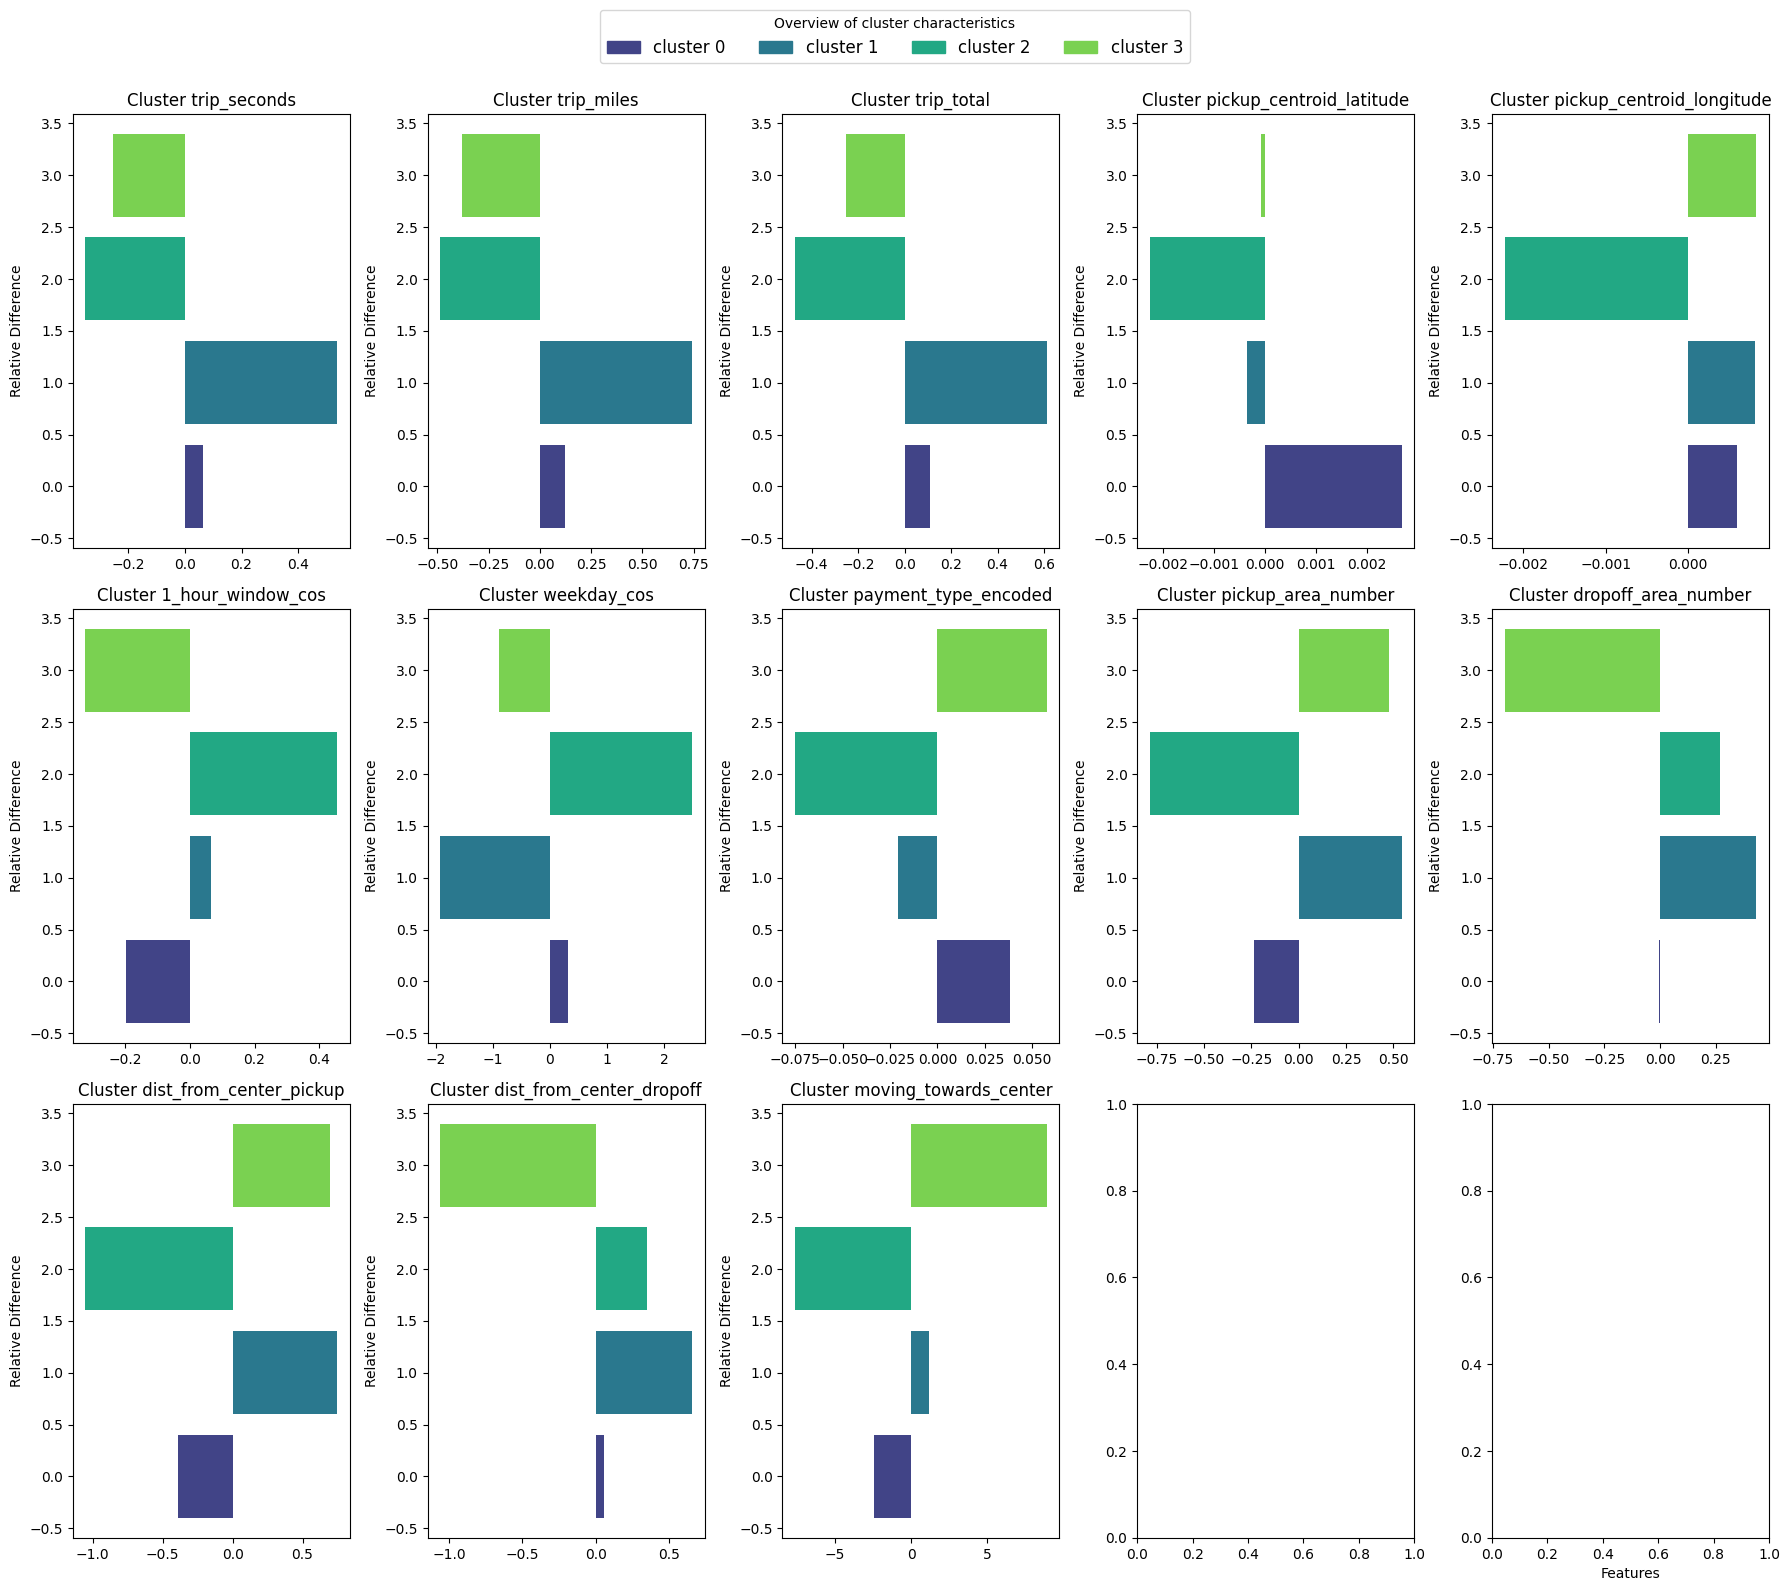

In [591]:
transposed_rd = relative_differences.T
transposed_rd.shape

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18,15))

colors = sns.color_palette('viridis', CLUSTER_NUMBER)

axes = axes.flatten()

for i, cluster in enumerate(transposed_rd.columns):
    axes[i].barh(transposed_rd.index, transposed_rd[cluster], color=colors, label=f'Cluster {cluster}')
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].set_ylabel('Relative Difference')


legend_patches = [mpatches.Patch(color=colors[i], label=f'cluster {i}') for i in range(CLUSTER_NUMBER)]
fig.legend(handles=legend_patches, title="Overview of cluster characteristics", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=CLUSTER_NUMBER, fontsize=12)

plt.tight_layout()
plt.xlabel('Features')
plt.show()

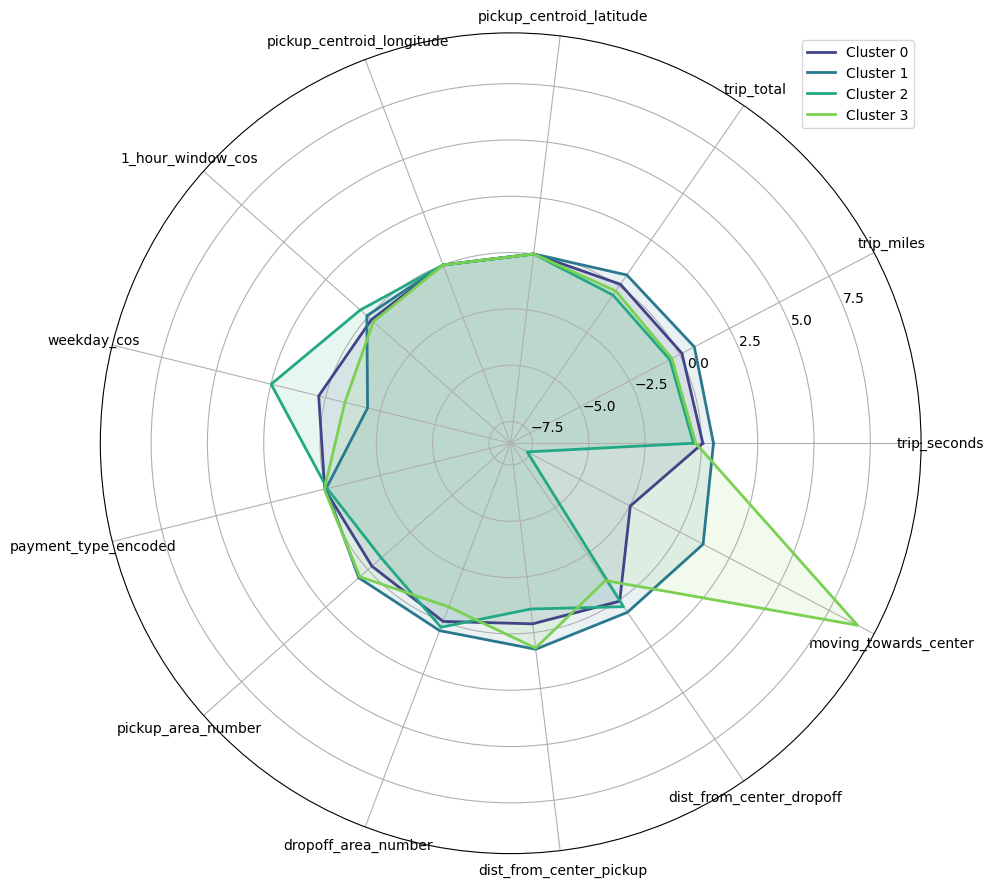

In [592]:
# Transpose for easier plotting
relative_differences.T

# Angle of axis = plot / number of variable
angles = [n / float(len(relative_differences.index)) * 2 * np.pi for n in range(len(relative_differences.index))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = sns.color_palette('viridis', len(relative_differences.columns))

for i, cluster in enumerate(relative_differences.columns):
    values = relative_differences[cluster].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster}", color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])


plt.xticks(angles[:-1], relative_differences.index)

plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

## 3.0 Clustering

After making the subsets with corresponding features, the dataframe df_geo_f has more than 4 features. For this, we want to take a look to reduce the amount via dimensionality reduction. But first we use the algorithm provided by...:_TODOOO

To decide on features for which we want to cluster, we thought about task relevant features but also tested around with an algorithm provided by https://medium.com/analytics-vidhya/k-means-algorithm-in-4-parts-4-4-42bc6c781e46.

Interesting Observations we can make from this:
- dist_from_center_pickup and trip_total as well as trip_miles
- pickup_area_number has similarly high correlations with trip_totla and trip_miles
- moving_towards_center has high correlation with pickup_area_number

In [ ]:
number_of_componentsPCA(df_selection_scaled)

In [ ]:
# Initalize globally
PCA_COMPONENTS = 4

In [ ]:
# Additionally reduce dim with PCA
pca_scaling = PCA(n_components=PCA_COMPONENTS)
pca_scaling_result = pca_scaling.fit_transform(df_selection_scaled)
explained_variance_scaling = pca_scaling.explained_variance_ratio_

In [ ]:
pca_components_df = pd.DataFrame(pca_scaling.components_, columns=df_selection.columns, index=['PC-1', 'PC-2', 'PC-3', 'PC-4']).T
for column in pca_components_df.columns:
    print(f"\nFeatures with high correlation for {column}: ")
    for index, value in pca_components_df[column].items():
        if np.abs(value) > 0.4:
            print(f"{index}: {value}")
            
pca_components_df

In [ ]:
# Plot the explained variance ratios
plt.figure(figsize=(6, 5))
colors = sns.color_palette('viridis', PCA_COMPONENTS)
for i in range(0, PCA_COMPONENTS):
    plt.barh(df_selection.columns, pca_scaling.components_[i], label=f'PC-{i+1}', color=colors[i])

plt.title('Features with their highest PCA value')
plt.legend()
plt.show()

For each PCA Component we can see that:
- PC-1: trip_miles increases so does trip_total,...

### 3.3 Clustering with kmeans++ and GMM

In [ ]:
df_cluster = df_selection.copy()

In [ ]:
# Run kmeans++ (10 iterations)
kmeans = KMeans(n_clusters = CLUSTER_NUMBER, n_init=10)
df_cluster['cluster_kmeans++'] = kmeans.fit_predict(df_selection_scaled)

In [ ]:
visualize_cluster_representative_power(CLUSTER_NUMBER, df_cluster, 'cluster_kmeans++', kmeans.cluster_centers_, df_selection_scaled)

In [ ]:
# kmeans++ with PCA 
kmeans_pca = KMeans(n_clusters = CLUSTER_NUMBER, n_init=10)
kmeans_pca.fit(pca_scaling_result)
cluster_labels = kmeans_pca.labels_

In [ ]:
# Create a DataFrame from the PCA results
pca_df = pd.DataFrame(pca_scaling_result, columns=[f'PC{i+1}' for i in range(pca_scaling_result.shape[1])])
pca_df["cluster_kmeans++"] = kmeans_pca.labels_

visualize_cluster_representative_power(CLUSTER_NUMBER, pca_df, "cluster_kmeans++",kmeans_pca.cluster_centers_,pca_scaling_result)

In [ ]:
# Run Gaussian Mixture Model
gmm = GaussianMixture(n_components = CLUSTER_NUMBER)
gmm.fit(df_selection_scaled)
df_selection["cluster_gmm"] = gmm.predict(df_selection_scaled)

In [ ]:
visualize_cluster_representative_power(CLUSTER_NUMBER, df_selection, 'cluster_gmm', kmeans.cluster_centers_, df_selection_scaled)

In [ ]:
def plt_violins(dataframe):
        """
        Method to plot violin charts of the clustering results including a bar plot of the cluster sizes.
        """
 
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))

        fig, axes = plt.subplots(nrows = len(feature_cols) + 1, ncols = len(cluster_cols), figsize = (20,15))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                for feature_id, feat in enumerate(feature_cols):
                        sns.violinplot(ax = axes[feature_id, cluster_id], x=dataframe[cluster_col], y=dataframe[feat], data=dataframe)
                        axes[feature_id, cluster_id].set_title(f'{cluster_col} - {feat}')
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[len(feature_cols), cluster_id].bar(cluster_size.index, cluster_size)
                axes[len(feature_cols), cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()